# Learn to find optimal pulses with automated optimization
**Use closed-loop optimization without a complete system model**

In this tutorial you will optimize a control pulse which implements a single-qubit gate on a simulated realistic experiment.
You will set up a [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) closed-loop optimizer which will keep suggesting new pulses to try in the experiment, in order to find one which minimizes the gate infidelity.

The [closed-loop optimization features](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/closed_loop) in Boulder Opal executes a closed optimization loop where the optimizer communicates with the experimental apparatus without your direct involvement.
In this kind of setting, your experimental apparatus produces an initial set of results, which it sends to the optimizer.
Using this information, the optimizer produces a set of improved test points (which in this case are controls) that it recommends back to the experimental apparatus.
The results corresponding to these test points are sent back to the optimizer, and the cycle repeats itself until any of the results has a sufficiently low cost function value, or until it meets any other ending condition that you imposed.
This setup is illustrated in the figure below.





## Obtaining an optimal pulse to implement a single qubit gate

Your task is to find an optimal pulse which implements an X gate on a qubit by using Boulder Opal's closed-loop optimizer.
You would usually do this for an experiment, but in this case you will interact with a simulated qubit implemented by the `run_experiments` function below. 

The system simulated in `run_experiments` is a qubit with leakage to a higher level, thus it's a three level system.
The qubit starts in state $|0\rangle$ and is evolved by the controls.
The function returns measurements of what level the qubit is in, either 0, 1 or 2.
Our goal of implementing an X gate corresponds to evolving the qubit from state $|0\rangle$ to state $|1\rangle$.

Do not worry about the exact details of this function, just think of it as a function that interacts with the experiment for which you want to find the optimal gate.
It takes in an array of `controls`, a `duration`, and a `shot_count`, and returns an array of `measurements` on the qubit associated with each control and shot.

In [1]:
def run_experiments(controls, duration, shot_count):
    """
    Simulates a single qubit experiment using Boulder Opal
    with the given piecewise-constant controls.

    Parameters
    ----------
    controls : np.ndarray
        The controls to simulate.
        A 2D NumPy array of shape (control_count, segment_count)
        with the per-segment values of each control.
    duration : float
        The duration (in nanoseconds) of the controls.
    shot_count : int
        The number of shots for which to generate measurements.

    Returns
    -------
    np.ndarray
        The qubit measurement results (either 0, 1, or 2) associated to each control
        and shot, as an array of shape (len(controls), shot_count).
    """

    # Create Boulder Opal graph.
    graph = bo.Graph()

    # Define simulation parameters and operators.
    filter_cutoff_frequency = 2 * np.pi * 0.3  # GHz
    segment_count = 128
    max_drive_amplitude = 2 * np.pi * 0.1  # GHz
    delta = -0.33 * 2 * np.pi  # GHz
    big_delta = 0.01 * 2 * np.pi  # GHz
    number_operator = graph.number_operator(3)
    drive_operator = 0.5 * graph.annihilation_operator(3)
    confusion_matrix = np.array(
        [[0.99, 0.01, 0.01], [0.01, 0.98, 0.01], [0.0, 0.01, 0.98]]
    )

    # Retrieve control information.
    control_values = controls * max_drive_amplitude

    # Define initial state.
    initial_state = graph.fock_state(3, 0)

    # Construct constant Hamiltonian terms.
    frequency_term = big_delta * number_operator
    anharmonicity_term = (
        delta * (number_operator @ number_operator - number_operator) / 2
    )

    # Construct filtered drive.
    filtered_drive = graph.convolve_pwc(
        pwc=graph.pwc_signal(duration=duration, values=control_values),
        kernel=graph.sinc_convolution_kernel(filter_cutoff_frequency),
    )
    drive = graph.discretize_stf(filtered_drive, duration, segment_count)
    drive_term = graph.hermitian_part(drive * drive_operator)

    # Build Hamiltonian and calculate unitary evolution operators.
    hamiltonian = drive_term + frequency_term + anharmonicity_term
    unitary = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=np.array([duration])
    )
    unitary = unitary[:, -1]

    # Evolve initial state and calculate final (normalized) populations.
    final_state = unitary @ initial_state[:, None]
    populations = graph.abs(final_state) ** 2

    # Apply the confusion matrix to the populations.
    populations = confusion_matrix @ populations
    populations.name = "populations"

    # Execute graph and retrieve the populations.
    result = bo.execute_graph(graph, "populations")
    populations = result["output"]["populations"]["value"].squeeze(axis=2)

    # Simulate measurements for each control.
    measurements_list = []
    for p in populations:
        # Sample and store measurements.
        measurements = rng.choice(3, size=shot_count, p=p / np.sum(p))
        measurements_list.append(measurements)

    return np.array(measurements_list)

### 1. Import libraries

Before doing any calculation with Boulder Opal, you always need to import the necessary libraries.

In this case, import the `numpy`, `matplotlib.pyplot`, `qctrlvisualizer`, and `boulderopal` packages.
To learn more about installing Boulder Opal, see the [Get started](https://docs.q-ctrl.com/boulder-opal/get-started) guide.

In [2]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

# Mute messages from Boulder Opal calls.
bo.cloud.set_verbosity("QUIET")

### 2. Configure closed-loop optimization

#### Define the bounds

First, define the per-parameter bounds on the test points, which limit the values the controls generated by the optimizer can take.
As there's no reason to treat any of the pulse segments differently, use uniform bounds, with a lower bound of 0 and an upper one of 1.
Create an array of shape `(segment_count, 2)` representing the lower and upper bounds for each optimization parameter, and use it to create a `boulderopal.closed_loop.Bounds` object.

In [3]:
# Number of segments in the control.
segment_count = 10

# Duration of each control.
duration = 100  # ns

# Number of projective measurements to take after the control is applied.
shot_count = 1000

# Define optimization bounds.
bounds = bo.closed_loop.Bounds(np.repeat([[0.0, 1.0]], segment_count, axis=0))

#### Define the optimizer

Next, you will set up a [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) optimizer to carry out your optimization.
You can read our [Choosing a control-design (optimization) strategy in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/choosing-a-control-design-optimization-strategy-in-boulder-opal#closed-loop-experimental-optimization) topic to learn more about the optimization routines available in Boulder Opal.
Each one of them has their own strengths, and will require a slightly different setup in this step.

Create a `boulderopal.closed_loop.Cmaes` object with the bounds for the optimization parameters.
You can also pass it an integer `seed` for the random number generator that the optimizer will use internally if you want the optimizer to generate deterministic results.

In [4]:
# Define the closed-loop optimizer.
optimizer = bo.closed_loop.Cmaes(bounds=bounds, seed=0)

#### Create a function to calculate the cost from the controls

The optimizer will aim to find the minimum of a cost function that takes in a set of parameters (controls) and returns their associated costs. In this case, the cost function must be suitable for the task of performing an X gate on the qubit. As this is equivalent to maximizing the probability of finding the qubit in state $|1\rangle$, define the cost for each control as one minus the probability of finding the qubit in state $|1\rangle$.

This can be calculated by calling the experiment function (`run_experiments`) which returns an array with the qubit measurements associated to each control. 
For each control, the measurements are a list of 0, 1, or 2, corresponding to the measured qubit state after the control is applied.

In [5]:
# Calculate cost from experiment results.
def cost_function(controls, duration, shot_count):
    """
    Accepts an array of controls and returns their associated costs.
    """
    measurements = run_experiments(controls, duration, shot_count)

    costs = []
    for shots in measurements:
        shots_in_one = np.count_nonzero(shots == 1)
        fidelity = shots_in_one / len(shots)
        costs.append(1 - fidelity)

    return np.array(costs)

#### Create an initial set of results to seed the optimizer

Next, you need to create a set of initial controls.
If you had some pulses that you want to refine you could use those, but since you don't, you can generate a random set of pulses.

Start by defining the parameters for the controls that you want to obtain, the number of piecewise-constant segments and the duration.
Next we define the experimental parameters, the number of projective measurements (shots) you want to take after each control and the number of controls (test points) you want to test at each optimization iteration.
For the [the CMA-ES optimizer](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/closed_loop/Cmaes), it is recommended to make sure that `test_point_count` is at least $4 + 3 \log(N)$ where $N$ is the number of optimizable parameters.

With these parameters, create an array of shape `(test_point_count, segment_count)` random values for the controls to start the optimization with.

In [6]:
# Number of controls to retrieve from the optimizer each run.
test_point_count = 40

# Define parameters as a set of controls with piecewise-constant segments.
rng = np.random.default_rng(seed=0)
initial_controls = rng.uniform(0.0, 1.0, size=(test_point_count, segment_count))

### 3. Execute optimization loop

You now have all of the elements to create a closed optimization loop to obtain the best controls.

To run the closed-loop optimization, use the function `boulderopal.closed_loop.optimize`. This starts an iterative cycle, where on each iteration the optimizer suggests new test points predicted to have a low cost.
This cycle keeps going until the best cost is lower than the target cost, `target_cost`.

It is a good idea to set a maximum number of iterations in case the problem is hard for the optimizer to converge.

The function will return a dictionary with the results of the optimization, namely, the best parameters `parameters`, their associated cost `cost`, and the history of best cost values `cost_history`.

In [7]:
# Maximum number of closed-loop iterations to perform.
max_iteration_count = 20

# Target cost to achieve.
target_cost = 0.02

# Run the optimization loop until the cost (infidelity) is sufficiently small.
results = bo.closed_loop.optimize(
    cost_function=lambda controls: cost_function(
        controls, duration=duration, shot_count=shot_count
    ),
    initial_parameters=initial_controls,
    optimizer=optimizer,
    target_cost=target_cost,
    max_iteration_count=max_iteration_count,
)

Running closed loop optimization
-----------------------------------------------
  Optimizer             : CMA-ES
  Number of test points : 40
  Number of parameters  : 10
-----------------------------------------------

Calling cost function…
  Initial best cost: 8.600e-02

Running optimizer…
Calling cost function…
  Best cost after 1 iterations: 5.900e-02

Running optimizer…
Calling cost function…
  Best cost after 2 iterations: 5.900e-02

Running optimizer…
Calling cost function…
  Best cost after 3 iterations: 4.900e-02

Running optimizer…
Calling cost function…
  Best cost after 4 iterations: 4.900e-02

Running optimizer…
Calling cost function…
  Best cost after 5 iterations: 4.900e-02

Running optimizer…
Calling cost function…
  Best cost after 6 iterations: 4.900e-02

Running optimizer…
Calling cost function…
  Best cost after 7 iterations: 4.900e-02

Running optimizer…
Calling cost function…
  Best cost after 8 iterations: 4.900e-02

Running optimizer…
Calling cost function…
  

You can see that as the iterations progress, the best cost found by the optimizer gets smaller until it reaches the target cost and the optimization stops.

### 4. Retrieve the best results obtained by the optimizer

You can now print the best cost and controls the optimizer has achieved and visualize them with the [`plot_controls`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer/plot_controls) function from the Q-CTRL Visualizer.

Best cost reached: 0.019
Best control values: [0.363 0.518 0.353 0.34  0.    1.    0.234 0.576 0.401 0.775]


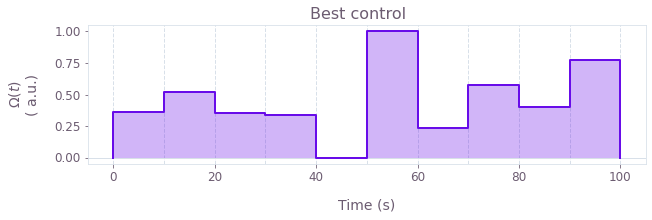

In [8]:
# Print final best cost.
print(f"Best cost reached: {results['cost']:.3f}")

# Print and plot controls that correspond to the best cost.
print(f"Best control values: {np.round(results['parameters'], 3)}")

qctrlvisualizer.plot_controls(
    {
        r"$\Omega(t)$": {
            "durations": np.repeat(duration / segment_count, segment_count),
            "values": results["parameters"],
        }
    },
    two_pi_factor=False,
    unit_symbol=" a.u.",
)
plt.suptitle("Best control")

plt.show()

Notice that your result for the best control will look different to the one plotted here due to a different random initialization of the optimizer.

### 5. Visualize the convergence of the optimizer

You can also plot the cost history during the optimization, and see its decrease until it crosses the target threshold.
You can easily do this with the [`plot_cost_histories`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer/plot_cost_histories) function from the Q-CTRL Visualizer.

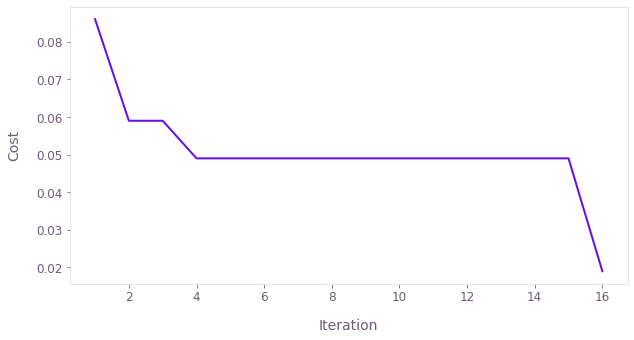

In [9]:
qctrlvisualizer.plot_cost_histories(results["cost_history"])

### 6. Compare initial and converged parameters

Finally we can compare the initial and optimized distributions of measurements.
For this plot, you will contrast the optimized controls with the best initial controls (the controls which have the highest probability of finding the qubit in $|1\rangle$).

As expected the converged controls perform substantially better than the random initial controls.

Best initial probabilities: [0.088 0.902 0.01 ]
Optimized probabilities: [0.009 0.98  0.011]


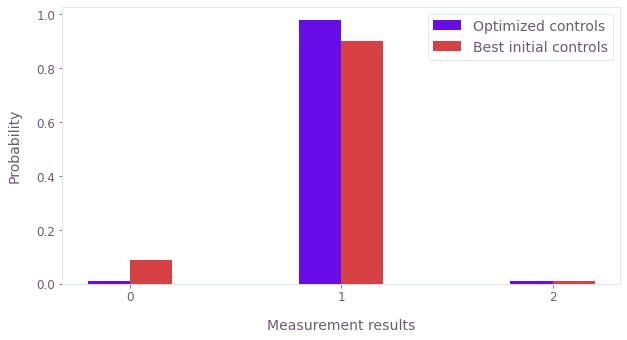

In [10]:
# Obtain a set of initial experimental results.
measurements = run_experiments(
    controls=initial_controls, duration=duration, shot_count=shot_count
)

# Find the best initial (random) control.
best_initial_control = np.argmax(np.count_nonzero(measurements == 1, axis=1))
initial_best_counts = np.unique(
    measurements[best_initial_control], return_counts=True, axis=0
)[1]
initial_best_probability = initial_best_counts / shot_count
print(f"Best initial probabilities: {initial_best_probability}")


# Obtain a set of converged experimental results.
measurements = run_experiments(
    controls=np.array([results["parameters"]]), duration=duration, shot_count=shot_count
)
optimized_counts = np.unique(measurements, return_counts=True)[1]
optimized_probability = optimized_counts / shot_count
print(f"Optimized probabilities: {optimized_probability}")

# Plot distribution of measurements for the initial & converged sets of pulses.
plt.bar(
    np.arange(3) - 0.1, optimized_probability, width=0.2, label="Optimized controls"
)
plt.bar(
    np.arange(3) + 0.1,
    initial_best_probability,
    width=0.2,
    label="Best initial controls",
)
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Measurement results")
plt.xticks(np.arange(3))

plt.show()

This concludes the tutorial. Congratulations on running a closed-loop optimization!

You can now try to change the optimization loop you are running here by changing the optimization parameters or using a different [optimizer](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/closed_loop#classes).
You can also play around with the function simulating the experiment and, for instance, make it harder or easier for the optimizer to find solutions by changing the confusion matrix or the anharmonicity in the system.

Our [user guides](https://docs.q-ctrl.com/boulder-opal/user-guides/) offer more examples and problems to which you can apply this automated optimization tool.
In particular, you might be interested in reading about [obtaining optimal controls with other closed-loop optimization routines](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-automate-closed-loop-hardware-optimization) or [calibrating control hardware](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-automate-calibration-of-control-hardware).

If you want to learn more about Boulder Opal and its capabilities, visit our [topics page](https://docs.q-ctrl.com/boulder-opal/topics).